This notebook allows to perform inference using a trained model

In [1]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
import ast
import glob
import shutil
import sys
import numpy as np
import imagesize
import cv2
from tqdm.notebook import tqdm
from typing import List
import torch
from torchvision.ops import box_iou
from typing import List
import torch
from torchvision.ops import box_iou
import warnings
warnings.filterwarnings('ignore')

In [2]:
import cv2
import torch
from PIL import Image


In [9]:
# load best model
model = torch.hub.load('/media/peter/2TB/julien/mlproject/great-barrier-reef/yolov5', 'custom', 
                       path='/media/peter/2TB/julien/mlproject/great-barrier-reef/yolov5/runs/train/exp9/weights/best.pt', source='local')  # local repo


In [4]:
# Conversion des annotations entre coco et yolo
def coco2yolo(image_height, image_width, bboxes):
    """
    coco => [xmin, ymin, w, h]
    yolo => [xmid, ymid, w, h] (normalized)
    """
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # normalizinig
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]/ image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]/ image_height
    
    # converstion (xmin, ymin) => (xmid, ymid)
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]/2
    
    return bboxes

def yolo2coco(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    coco => [xmin, ymin, w, h]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    # denormalizing
    bboxes[..., [0, 2]]= bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]]= bboxes[..., [1, 3]]* image_height
    
    # converstion (xmid, ymid) => (xmin, ymin) 
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    
    return bboxes

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)


def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)

def draw_bboxes(img, bbox_np, classes, class_ids, labels_colors, colors = None, show_classes = None, bbox_format = 'yolo', class_name = False, line_thickness = 2):  
     
    image = img.copy()
    show_classes = classes if show_classes is None else show_classes
    colors = (0, 255 ,0) if colors is None else colors
    
    if bbox_format == 'yolo':
        
        for idx in range(len(bbox_np)):  
            
            bbox  = bbox_np[idx]
            cls   = classes[idx]
            cls_id = class_ids[idx]
            color = colors[labels_colors[idx]] if type(colors) is list else colors
            
            if cls in show_classes:
            
                x1 = round(float(bbox[0])*image.shape[1])
                y1 = round(float(bbox[1])*image.shape[0])
                w  = round(float(bbox[2])*image.shape[1]/2) #w/2 
                h  = round(float(bbox[3])*image.shape[0]/2)

                voc_bbox = (x1, y1, x1+2*w, y1+2*h)
                plot_one_box(voc_bbox, 
                             image,
                             color = color,
                             label = cls if class_name else str(get_label(cls)),
                             line_thickness = line_thickness)
    else:
        raise ValueError('wrong bbox format')

    return image

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

In [74]:
bbox_np = []
labels_loaded = np.genfromtxt('datasets/labels/video_0_100.txt')
list_bbox = model(img_loaded).pred[0].cpu().numpy().tolist()
for i in range(len(list_bbox)):
    sub_list = model(img_loaded).pred[0].cpu().numpy().tolist()[i]
    bbox_np.append([sub_list[0]/1280, sub_list[1]/720, (sub_list[2]-sub_list[0])/1280, (sub_list[3]-sub_list[1])/720])
if labels_loaded.ndim == 1:
    sub_list = labels_loaded[1:].tolist()
    bbox_np.append([(sub_list[0]-sub_list[2]/2), sub_list[1]-sub_list[3]/2, sub_list[2], sub_list[3]])
else:
    for i in range(labels_loaded.shape[0]):
        sub_list = labels_loaded[i, 1:].tolist()
        bbox_np.append([(sub_list[0]-sub_list[2]/2), sub_list[1]-sub_list[3]/2, sub_list[2], sub_list[3]])


In [68]:
labels_true_model = []
for i in range(len(list_bbox)):
    labels_true_model.append(0)
for i in np.arange(len(list_bbox), len(bbox_np)):
    labels_true_model.append(1)
 

In [69]:
# bbox_np = [[278.04/1280, 636.86/720, (381.26-278.04)/1280, (717.96-636.86)/720],
#           [587.98/1280, 86.909/720, (631.17-587.98)/1280, (122.34-86.909)/720]]
names = ['starfish']*len(bbox_np)
labels = [0]*len(bbox_np)
# colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
#           for idx in range(1)]


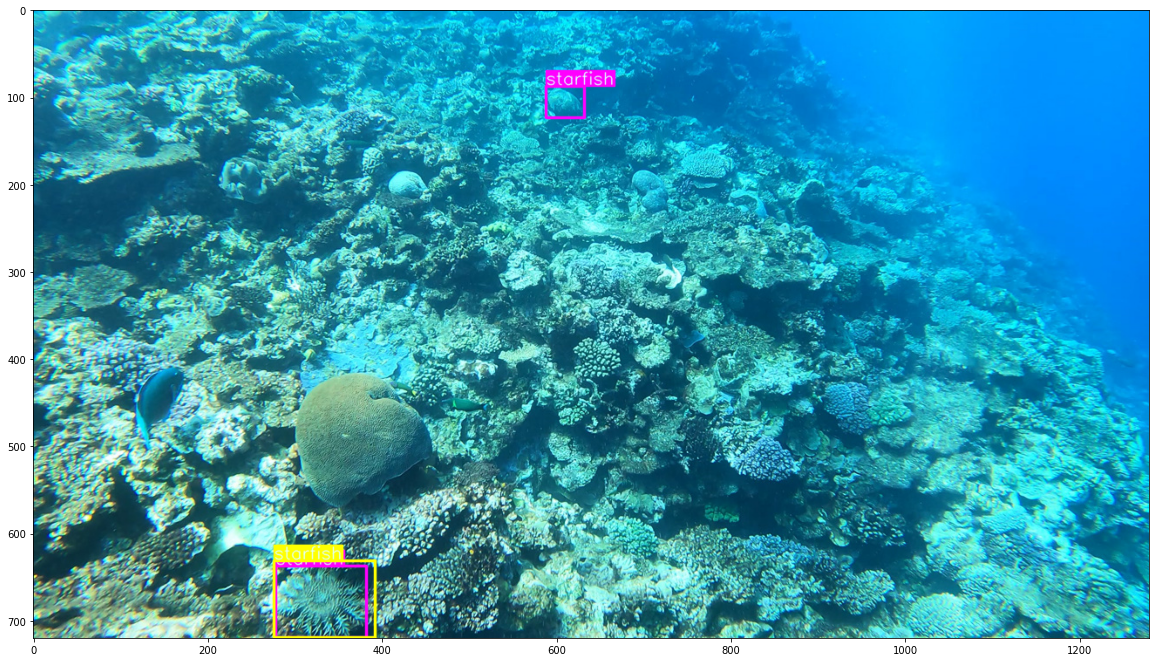

In [75]:
%matplotlib inline
plt.figure(figsize = (20, 12))
plt.imshow(draw_bboxes(img = img_loaded,
                       bbox_np = bbox_np, 
                       classes = names,
                       class_ids = labels,
                       labels_colors = labels_true_model,
                       class_name = True, 
                       colors = [(255,0,255), (255,255,0)], 
                       bbox_format = 'yolo',
                       line_thickness = 2))
# plt.axis('OFF')
plt.show()


# Create Video 

In [5]:
ROOT_DIR  = '/media/peter/2TB/julien/mlproject/great-barrier-reef'
WORKING_DIR  = '/media/peter/2TB/julien/mlproject/great-barrier-reef'
NUM_IMAGES = 9962


In [7]:
for im_num in tqdm(np.arange(7652,NUM_IMAGES)):
    image_path = f'{ROOT_DIR}/train_images/video_0/{im_num}.jpg'
    labels_path = f'{ROOT_DIR}/datasets/labels/video_0_{im_num}.txt'
    if os.path.exists(image_path):

        img_loaded = load_image(image_path)

        bbox_np = []

        labeled= False
        if os.path.exists(labels_path):
            labeled= True
            labels_loaded = np.genfromtxt(labels_path)

        list_bbox = model(img_loaded).pred[0].cpu().numpy().tolist()

        for i in range(len(list_bbox)):
            sub_list = model(img_loaded).pred[0].cpu().numpy().tolist()[i]
            bbox_np.append([sub_list[0]/1280, sub_list[1]/720, (sub_list[2]-sub_list[0])/1280, (sub_list[3]-sub_list[1])/720])
        if labeled:
            if labels_loaded.ndim == 1:
                sub_list = labels_loaded[1:].tolist()
                bbox_np.append([(sub_list[0]-sub_list[2]/2), sub_list[1]-sub_list[3]/2, sub_list[2], sub_list[3]])
            else:
                for i in range(labels_loaded.shape[0]):
                    sub_list = labels_loaded[i, 1:].tolist()
                    bbox_np.append([(sub_list[0]-sub_list[2]/2), sub_list[1]-sub_list[3]/2, sub_list[2], sub_list[3]])

        labels_true_model = []
        for i in range(len(list_bbox)):
            labels_true_model.append(0)
        if labeled:
            for i in np.arange(len(list_bbox), len(bbox_np)):
                labels_true_model.append(1)

        names = ['starfish']*len(bbox_np)
        labels = [0]*len(bbox_np)

        plt.figure(figsize = (20, 12))
        plt.imshow(draw_bboxes(img = img_loaded,
                               bbox_np = bbox_np, 
                               classes = names,
                               class_ids = labels,
                               labels_colors = labels_true_model,
                               class_name = True, 
                               colors = [(255,0,255), (255,255,0)], 
                               bbox_format = 'yolo',
                               line_thickness = 2))
        # plt.axis('OFF')
        plt.savefig(f'presentation_video/{im_num}.jpg')
        plt.close()

    else:
        print(im_num)

  0%|          | 0/2310 [00:00<?, ?it/s]

7652
7653
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
